## Musinsa Customal's Viewpoint - Product Ranking

    작성자 : 조예슬
    
    소비자들의 조회수, 판매수가 높을 수록 관심이 높다고 판단
    상품 랭킹이 소비자 관심에 미치는 영향은 어떤지 알아보기
    
    - MySQL을 이용하여 데이터 전처리 진행
    - 상품 랭킹 내에서 판매량이 가장 높은 대분류 4가지 뽑기
    - 대분류 4가지(상의, 아우터, 바지, 스니커)의 판매수 평균 내고, 시각화 시키기

In [32]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt                                                 # 실제로 그래프를 그려주는 애
import seaborn as sns

import matplotlib.font_manager as fm                                            # 한글폰트 안깨져서 나오게하기위해
font_name = fm.FontProperties(fname="C:\Windows/Fonts/malgun.ttf").get_name()    # 폰트 지정
plt.rc('font', family=font_name)                                                 # matplotlib내에 폰트 설정

mpl.rcParams["axes.unicode_minus"] = False        # 음수 설정, False로 지정하면 음수를 문자로 쓰지않고 숫자로 지정하겠다는 의미, 음수로 사용이 가능해진다.

import MySQLdb

In [34]:
config = {"host":"192.168.0.44", "user":"musinsa", "password":"1111", "database":"PR_TEST", "charset":'utf8'}
conn = MySQLdb.connect(**config)

In [35]:
# 상품 랭킹 데이터 전처리 

cursor = conn.cursor()  

sql = """SELECT PRDT_CODE, ROUND(AVG(PRDT_RANK), 0) AS P_RANK
FROM RANK_ALL 
GROUP BY PRDT_CODE;"""
                      
cursor.execute(sql) 

arr = cursor.fetchall()

P_rank_columns = ["PRDT_CODE","PRDT_RANK"]

P_RANK= pd.DataFrame(arr, columns=P_rank_columns)

# string -> float
P_RANK["PRDT_RANK"] = P_RANK["PRDT_RANK"].astype(float)

P_RANK

,PRDT_CODE,PRDT_RANK
0,1000048,4122.0
1,1000087,7767.0
2,1000088,7458.0
3,1000112,4038.0
4,1000122,5729.0
...,...,...
31680,999928,5182.0
31681,999929,5404.0
31682,999932,6225.0
31683,999939,3732.0


In [36]:
# 상품 판매량 데이터 전처리 

cursor = conn.cursor()  

sql = """SELECT PRDT_CODE, SUM(PUR_CNT) AS P_CNT
FROM PRDT_PURCHASE 
WHERE PUR_CNT <= 100000
GROUP BY PRDT_CODE
HAVING P_CNT != 0
ORDER BY P_CNT ASC;"""
                      
cursor.execute(sql) 

arr = cursor.fetchall()

PUR_columns = ["PRDT_CODE", "PUR_CNT"]

PUR= pd.DataFrame(arr, columns=PUR_columns)

# string -> float
PUR["PUR_CNT"] = PUR["PUR_CNT"].astype(float)

PUR

,PRDT_CODE,PUR_CNT
0,1213323,41.0
1,1152498,41.0
2,826501,41.0
3,826935,41.0
4,1210734,41.0
...,...,...
11055,996178,51148.0
11056,466080,52553.0
11057,1149328,63544.0
11058,659554,72737.0


In [37]:
# 상품 랭킹 + 판매량
PRDT = pd.merge(P_RANK, PUR, on="PRDT_CODE")
PRDT

,PRDT_CODE,PRDT_RANK,PUR_CNT
0,1000048,4122.0,308.0
1,1000112,4038.0,149.0
2,1000190,6378.0,61.0
3,1000210,2997.0,72.0
4,1000498,4550.0,150.0
...,...,...,...
8397,999444,2258.0,71.0
8398,999449,3616.0,748.0
8399,999650,7638.0,42.0
8400,999706,7443.0,43.0


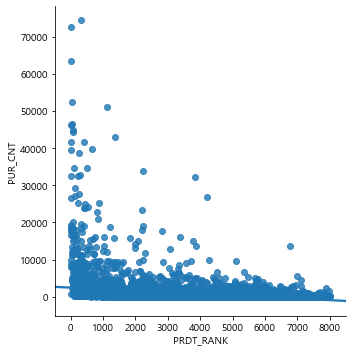

In [38]:
# 상품 랭킹 + 판매량 시각화
sns.lmplot(x = "PRDT_RANK", y = "PUR_CNT", data = PRDT)

In [62]:
# 상품 카테고리 데이터 전처리 

cursor = conn.cursor()  

sql = """SELECT P.PRDT_CODE,  C.MAJOR_CODE
FROM PRDT_INFO P, CATEGORY C
WHERE P.SUB_CODE = C.SUB_CODE
  AND C.MAJOR_CODE IN ('001', '002', '003', '018')
ORDER BY C.MAJOR_CODE ASC;"""
                      
cursor.execute(sql) 

arr = cursor.fetchall()

CA_columns = ["PRDT_CODE", "MAJOR_CODE"]

CA= pd.DataFrame(arr, columns=CA_columns)

CA

,PRDT_CODE,MAJOR_CODE
0,1124214,001
1,1199804,001
2,799761,001
3,1023951,001
4,565940,001
...,...,...
68703,1224996,018
68704,1124321,018
68705,1131087,018
68706,998768,018


In [63]:
# 상품 랭킹 + 판매량 + 카테고리
TOTAL = pd.merge(PRDT, CA, on="PRDT_CODE", how="left")
TOTAL

,PRDT_CODE,PRDT_RANK,PUR_CNT,MAJOR_CODE
0,1000048,4122.0,308.0,003
1,1000112,4038.0,149.0,003
2,1000190,6378.0,61.0,003
3,1000210,2997.0,72.0,001
4,1000498,4550.0,150.0,003
...,...,...,...,...
8397,999444,2258.0,71.0,NaN
8398,999449,3616.0,748.0,003
8399,999650,7638.0,42.0,NaN
8400,999706,7443.0,43.0,NaN


In [68]:
TOTAL = TOTAL.loc[(TOTAL["PRDT_RANK"] < 500) & (TOTAL["PUR_CNT"] <1000)]
TOTAL.sort_values(by="PRDT_RANK", ascending=True)


,PRDT_CODE,PRDT_RANK,PUR_CNT,MAJOR_CODE
4749,1260749,16.0,601.0,018
4639,1251546,82.0,937.0,003
4752,1260752,117.0,104.0,018
5780,665782,139.0,713.0,NaN
4876,262039,142.0,48.0,002
7343,914738,173.0,215.0,002
3366,1191643,180.0,617.0,002
4317,1231416,184.0,943.0,003
3489,1194754,191.0,802.0,002
3401,1191965,206.0,431.0,002


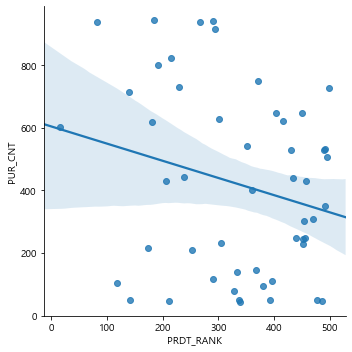

In [69]:
#  MAJOR = 1 : 시각화
sns.lmplot(x = "PRDT_RANK", y = "PUR_CNT", data = TOTAL)

In [64]:
#  MAJOR = 1
TOTAL1 = TOTAL.loc[TOTAL["MAJOR_CODE"] == "001"]
TOTAL1.sort_values(by="PRDT_RANK", ascending=True)

,PRDT_CODE,PRDT_RANK,PUR_CNT,MAJOR_CODE
3611,1199146,3.0,18309.0,001
5751,659554,17.0,72737.0,001
5689,643173,50.0,13323.0,001
7202,897632,55.0,46504.0,001
1509,1129701,61.0,12706.0,001
...,...,...,...,...
2450,1158863,6448.0,611.0,001
6206,747290,6454.0,228.0,001
4491,1242019,6525.0,66.0,001
6999,880757,6595.0,41.0,001


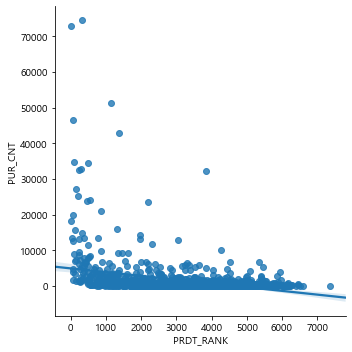

In [65]:
#  MAJOR = 1 : 시각화
sns.lmplot(x = "PRDT_RANK", y = "PUR_CNT", data = TOTAL1)

In [20]:
#  MAJOR = 2
TOTAL2 = TOTAL.loc[TOTAL["MAJOR_CODE"] == "002"]
TOTAL2.sort_values(by="PUR_CNT", ascending=False)

,PRDT_CODE,PRDT_RANK,PUR_CNT,MAJOR_CODE
5522,606312,58.0,44782.0,002
893,1108007,9.0,39541.0,002
6822,865862,7.0,16572.0,002
5617,635788,1032.0,16164.0,002
8176,982592,2077.0,15074.0,002
...,...,...,...,...
2478,1160146,2031.0,41.0,002
7716,947756,2929.0,41.0,002
1766,1138776,2809.0,41.0,002
6353,803445,1267.0,41.0,002


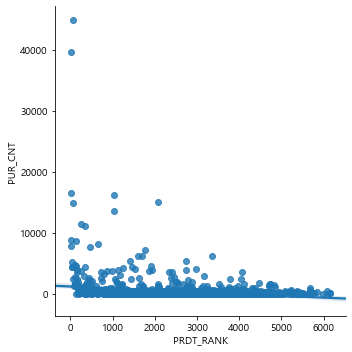

In [21]:
#  MAJOR = 2 : 시각화
sns.lmplot(x = "PRDT_RANK", y = "PUR_CNT", data = TOTAL2)

In [24]:
#  MAJOR = 3
TOTAL3 = TOTAL.loc[TOTAL["MAJOR_CODE"] == "003"]
TOTAL3.sort_values(by="PUR_CNT", ascending=False)

,PRDT_CODE,PRDT_RANK,PUR_CNT,MAJOR_CODE
2121,1149328,4.0,63544.0,003
8130,978464,3.0,46317.0,003
2122,1149329,8.0,41643.0,003
8120,977043,262.0,38802.0,003
7877,957880,21.0,32481.0,003
...,...,...,...,...
2496,1160487,2904.0,41.0,003
2296,1153632,4838.0,41.0,003
4618,1251551,3582.0,41.0,003
3680,1204199,5162.0,41.0,003


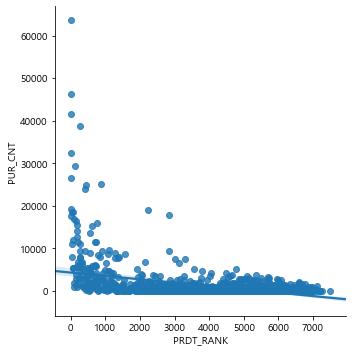

In [25]:
#  MAJOR = 3 : 시각화
sns.lmplot(x = "PRDT_RANK", y = "PUR_CNT", data = TOTAL3)

In [26]:
#  MAJOR = 18
TOTAL18 = TOTAL.loc[TOTAL["MAJOR_CODE"] == "018"]
TOTAL18.sort_values(by="PUR_CNT", ascending=False)

,PRDT_CODE,PRDT_RANK,PUR_CNT,MAJOR_CODE
311,104241,2227.0,33890.0,018
4783,166013,4216.0,26751.0,018
4914,311052,806.0,22836.0,018
5443,577636,3.0,18887.0,018
6386,810034,162.0,18080.0,018
...,...,...,...,...
2705,1168229,4745.0,41.0,018
4740,1262230,1603.0,41.0,018
102,1012687,4748.0,41.0,018
2749,1170707,1500.0,41.0,018


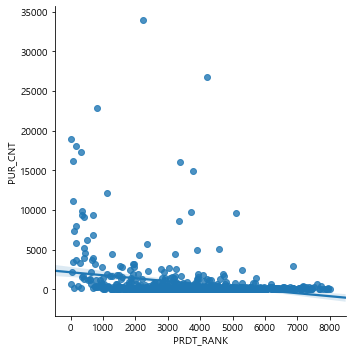

In [27]:
#  MAJOR = 18 : 시각화
sns.lmplot(x = "PRDT_RANK", y = "PUR_CNT", data = TOTAL18)

### 최종 결론

    상품 랭킹이 높으면 구매수가 높음을 알 수 있음
    하지만 상품 랭킹이 높기에 구매수가 높은건지
    구매수가 높기에 상품 랭킹이 높은건지
    어떤 것이 원인이고 결과인지 우리가 가지고있는 자료만 가지고서는 한계가 있음